In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from shared_logic import *

random_seed = 1
np.random.seed(random_seed)


In [2]:
plt.style.use('seaborn-colorblind')
# https://jwalton.info/Embed-Publication-Matplotlib-Latex/
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 11pt font in plots, to match 11pt font in document
    "axes.labelsize": 11,
    "font.size": 11
}
plt.rcParams.update(tex_fonts)


In [3]:
def calculate_precision(tp, fp):
    if tp + fp == 0:
        return 0
    return tp / (tp + fp)

In [4]:
def calculate_recall(tp, fn):
    if tp + fn == 0:
        return 0
    return tp / (tp + fn)

In [5]:
def get_TP_TN_FP_FN(actual, predicted):
    if actual == True and predicted == True:
        return 'TP'
    elif actual == False and predicted == False:
        return 'TN'
    elif actual == False and predicted == True:
        return 'FP'
    elif actual == True and predicted == False:
        return 'FN'
    else:
        raise ValueError(f'Invalid actual and predicted values: {actual} {predicted}')

In [6]:
stations_df = pd.read_csv('./data/stations.csv')
stations_dict = stations_df.groupby(['common_id']).first().to_dict('index')
common_id = '36022-ie'

tex_plots_path = f'../bachelor-thesis/plots/pdfs/{common_id}/'
tex_table_path = f'../bachelor-thesis/tables/{common_id}/'
if not os.path.exists(tex_plots_path):
    os.makedirs(tex_plots_path)
if not os.path.exists(tex_table_path):
    os.makedirs(tex_table_path)

prediction_summary_df = pd.read_parquet(
    './data/predictions/predictions_summary.parquet')
preprocessed_prediction_summary_df = pd.read_parquet(
    './data/predictions/predictions_preprocessed_summary.parquet')
prediction_summary_df = prediction_summary_df.loc[prediction_summary_df['model_type'] != 'delta-z-score']
prediction_summary_df['recall'] = prediction_summary_df.apply(lambda row: calculate_recall(row['tp'], row['fn']),
                                                              axis=1)
prediction_summary_df['precision'] = prediction_summary_df.apply(lambda row: calculate_precision(row['tp'], row['fp']),
                                                                 axis=1)
preprocessed_prediction_summary_df['recall'] = preprocessed_prediction_summary_df.apply(
    lambda row: calculate_recall(row['tp'], row['fn']), axis=1)
preprocessed_prediction_summary_df['precision'] = preprocessed_prediction_summary_df.apply(
    lambda row: calculate_precision(row['tp'], row['fp']), axis=1)


In [7]:
prediction_summary_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500000 entries, 300 to 1799999
Data columns (total 13 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   common_id      1500000 non-null  object 
 1   window_size    1470000 non-null  float64
 2   center_window  1500000 non-null  bool   
 3   model_type     1500000 non-null  object 
 4   normalized     1500000 non-null  bool   
 5   threshold      1500000 non-null  float64
 6   f1_score       1500000 non-null  float64
 7   tn             1500000 non-null  int64  
 8   fp             1500000 non-null  int64  
 9   fn             1500000 non-null  int64  
 10  tp             1500000 non-null  int64  
 11  recall         1500000 non-null  float64
 12  precision      1500000 non-null  float64
dtypes: bool(2), float64(5), int64(4), object(2)
memory usage: 140.2+ MB


In [8]:
prediction_summary_df['model_type'].unique()

array(['mean', 'z-score', 'median', 'madn-z-score', 'mad'], dtype=object)

In [9]:
preprocessed_prediction_summary_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800000 entries, 0 to 1799999
Data columns (total 13 columns):
 #   Column         Dtype  
---  ------         -----  
 0   common_id      object 
 1   window_size    float64
 2   center_window  bool   
 3   model_type     object 
 4   normalized     bool   
 5   threshold      float64
 6   f1_score       float64
 7   tn             int64  
 8   fp             int64  
 9   fn             int64  
 10  tp             int64  
 11  recall         float64
 12  precision      float64
dtypes: bool(2), float64(5), int64(4), object(2)
memory usage: 154.5+ MB


In [10]:
prediction_summary_df.groupby(['common_id', 'model_type']).any().reset_index()[['common_id', 'model_type']]

,common_id,model_type
0,2386-ch,mad
1,2386-ch,madn-z-score
2,2386-ch,mean
3,2386-ch,median
4,2386-ch,z-score
5,2720050000-de,mad
6,2720050000-de,madn-z-score
7,2720050000-de,mean
8,2720050000-de,median
9,2720050000-de,z-score


In [11]:
# get unique combination of common id and model type
# create a dictionary of dataframes for faster filtering
prediction_summaries_dict = {}
for idx, row in prediction_summary_df.groupby(['common_id', 'model_type']).any().reset_index()[
    ['common_id', 'model_type']].iterrows():
    prediction_summaries_dict[f'{row["common_id"]}'] = {
        'regular': prediction_summary_df.loc[prediction_summary_df['common_id'] == row['common_id']].copy(),
        'preprocessed': preprocessed_prediction_summary_df.loc[
            preprocessed_prediction_summary_df['common_id'] == row['common_id']].copy()
    }


In [65]:
common_id = '36022-ie'
tex_table_path = f'../bachelor-thesis/tables/{common_id}/'
model_types = prediction_summaries_dict[common_id]['regular']['model_type'].unique()
combined_df_lst = []
for model_type in model_types:
    tmp_df = prediction_summaries_dict[common_id]['regular']
    norm_df = tmp_df.loc[(tmp_df['model_type'] == model_type) & (tmp_df['normalized'])]
    combined_df_lst.append(norm_df.sort_values(by=['f1_score'], ascending=False).head(3))
    reg_df = tmp_df.loc[(tmp_df['model_type'] == model_type) & (~tmp_df['normalized'])]
    combined_df_lst.append(reg_df.sort_values(by=['f1_score'], ascending=False).head(3))
combined_df = pd.concat(combined_df_lst).sort_values(by=['f1_score', 'model_type'], ascending=False)
combined_df[['window_size', 'center_window', 'normalized', 'threshold', 'model_type', 'f1_score']].to_latex(
    f'{tex_table_path}/{common_id}-top-predictions-summary.tex', position='htp',
    label=f'table:{common_id}-top-predictions-summary', index=False,
    caption=f'Top predictions summary of {stations_dict[common_id]["water_name"]} - {stations_dict[common_id]["station_name"]}')
combined_df


/tmp/ipykernel_12770/3371635846.py:12: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  combined_df[['window_size', 'center_window', 'normalized', 'threshold', 'model_type', 'f1_score']].to_latex(


,common_id,window_size,center_window,model_type,normalized,threshold,f1_score,tn,fp,fn,tp,recall,precision
509420,36022-ie,5.0,True,median,False,7.622074,0.812550,26451,93,140,505,0.782946,0.844482
509422,36022-ie,5.0,True,median,False,8.284281,0.812348,26458,86,145,500,0.775194,0.853242
509421,36022-ie,5.0,True,median,False,7.953177,0.811688,26457,87,145,500,0.775194,0.851789
1420208,36022-ie,24.0,True,madn-z-score,True,3.648829,0.789205,26359,185,104,541,0.838760,0.745179
520208,36022-ie,24.0,True,madn-z-score,False,3.648829,0.789205,26359,185,104,541,0.838760,0.745179
1342808,36022-ie,22.0,True,madn-z-score,True,3.648829,0.787572,26350,194,100,545,0.844961,0.737483
442808,36022-ie,22.0,True,madn-z-score,False,3.648829,0.787572,26350,194,100,545,0.844961,0.737483
1323310,36022-ie,26.0,True,madn-z-score,True,4.311037,0.786415,26385,159,124,521,0.807752,0.766176
423310,36022-ie,26.0,True,madn-z-score,False,4.311037,0.786415,26385,159,124,521,0.807752,0.766176
1290000,36022-ie,9.0,True,median,True,1.000000,0.759430,26449,95,192,453,0.702326,0.826642


In [66]:
common_id = '36022-ie'
tex_table_path = f'../bachelor-thesis/tables/{common_id}/'
model_types = prediction_summaries_dict[common_id]['preprocessed']['model_type'].unique()
combined_df_lst = []
for model_type in model_types:
    tmp_df = prediction_summaries_dict[common_id]['preprocessed']
    norm_df = tmp_df.loc[(tmp_df['model_type'] == model_type) & (tmp_df['normalized'])]
    combined_df_lst.append(norm_df.sort_values(by=['f1_score'], ascending=False).head(3))
    reg_df = tmp_df.loc[(tmp_df['model_type'] == model_type) & (~tmp_df['normalized'])]
    combined_df_lst.append(reg_df.sort_values(by=['f1_score'], ascending=False).head(3))
combined_df = pd.concat(combined_df_lst).sort_values(by=['f1_score', 'model_type'], ascending=False)
# combined_df[['window_size', 'center_window', 'normalized', 'threshold', 'model_type', 'f1_score']].to_latex(
#     f'{tex_table_path}/{common_id}-top-predictions-summary.tex', position='htp',
#     label=f'table:{common_id}-top-predictions-summary', index=False,
#     caption=f'Top predictions summary of {stations_dict[common_id]["water_name"]} - {stations_dict[common_id]["station_name"]}')
combined_df


,common_id,window_size,center_window,model_type,normalized,threshold,f1_score,tn,fp,fn,tp,recall,precision
509420,36022-ie,5.0,True,median,False,7.622074,0.801025,26451,93,140,469,0.770115,0.834520
509422,36022-ie,5.0,True,median,False,8.284281,0.800690,26458,86,145,464,0.761905,0.843636
509421,36022-ie,5.0,True,median,False,7.953177,0.800000,26457,87,145,464,0.761905,0.842105
1420208,36022-ie,24.0,True,madn-z-score,True,3.648829,0.778802,26358,186,102,507,0.832512,0.731602
520208,36022-ie,24.0,True,madn-z-score,False,3.648829,0.778802,26358,186,102,507,0.832512,0.731602
1342808,36022-ie,22.0,True,madn-z-score,True,3.648829,0.777186,26349,195,98,511,0.839080,0.723796
442808,36022-ie,22.0,True,madn-z-score,False,3.648829,0.777186,26349,195,98,511,0.839080,0.723796
1323310,36022-ie,26.0,True,madn-z-score,True,4.311037,0.776096,26385,159,122,487,0.799672,0.753870
423310,36022-ie,26.0,True,madn-z-score,False,4.311037,0.776096,26385,159,122,487,0.799672,0.753870
1290000,36022-ie,9.0,True,median,True,1.000000,0.752212,26448,96,184,425,0.697865,0.815739


In [67]:
common_id = '2386-ch'
tex_table_path = f'../bachelor-thesis/tables/{common_id}/'
model_types = prediction_summaries_dict[common_id]['regular']['model_type'].unique()
combined_df_lst = []
for model_type in model_types:
    tmp_df = prediction_summaries_dict[common_id]['regular']
    norm_df = tmp_df.loc[(tmp_df['model_type'] == model_type) & (tmp_df['normalized'])]
    combined_df_lst.append(norm_df.sort_values(by=['f1_score'], ascending=False).head(3))
    reg_df = tmp_df.loc[(tmp_df['model_type'] == model_type) & (~tmp_df['normalized'])]
    combined_df_lst.append(reg_df.sort_values(by=['f1_score'], ascending=False).head(3))
combined_df = pd.concat(combined_df_lst).sort_values(by=['f1_score', 'model_type'], ascending=False)
combined_df[['window_size', 'center_window', 'normalized', 'threshold', 'model_type', 'f1_score']].to_latex(
    f'{tex_table_path}/{common_id}-top-predictions-summary.tex', position='htp',
    label=f'table:{common_id}-top-predictions-summary', index=False,
    caption=f'Top predictions summary of {stations_dict[common_id]["water_name"]} - {stations_dict[common_id]["station_name"]}')
combined_df

/tmp/ipykernel_12770/3016955501.py:12: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  combined_df[['window_size', 'center_window', 'normalized', 'threshold', 'model_type', 'f1_score']].to_latex(


,common_id,window_size,center_window,model_type,normalized,threshold,f1_score,tn,fp,fn,tp,recall,precision
9915,2386-ch,3.0,True,median,False,5.966555,0.657895,50423,44,34,75,0.688073,0.630252
9914,2386-ch,3.0,True,median,False,5.635452,0.649351,50420,47,34,75,0.688073,0.614754
9917,2386-ch,3.0,True,median,False,6.628763,0.639175,50444,23,47,62,0.568807,0.729412
5111,2386-ch,3.0,True,mean,False,4.642140,0.447917,50278,189,23,86,0.788991,0.312727
5112,2386-ch,3.0,True,mean,False,4.973244,0.443804,50306,161,32,77,0.706422,0.323529
5113,2386-ch,3.0,True,mean,False,5.304348,0.429907,50324,143,40,69,0.633028,0.325472
956409,2386-ch,50.0,True,z-score,True,3.979933,0.327273,50438,29,82,27,0.247706,0.482143
56409,2386-ch,50.0,True,z-score,False,3.979933,0.327273,50438,29,82,27,0.247706,0.482143
921908,2386-ch,49.0,True,z-score,True,3.648829,0.306931,50405,62,78,31,0.284404,0.333333
21908,2386-ch,49.0,True,z-score,False,3.648829,0.306931,50405,62,78,31,0.284404,0.333333


In [68]:
common_id = '2386-ch'
tex_table_path = f'../bachelor-thesis/tables/{common_id}/'
model_types = prediction_summaries_dict[common_id]['preprocessed']['model_type'].unique()
combined_df_lst = []
for model_type in model_types:
    tmp_df = prediction_summaries_dict[common_id]['preprocessed']
    norm_df = tmp_df.loc[(tmp_df['model_type'] == model_type) & (tmp_df['normalized'])]
    combined_df_lst.append(norm_df.sort_values(by=['f1_score'], ascending=False).head(3))
    reg_df = tmp_df.loc[(tmp_df['model_type'] == model_type) & (~tmp_df['normalized'])]
    combined_df_lst.append(reg_df.sort_values(by=['f1_score'], ascending=False).head(3))
combined_df = pd.concat(combined_df_lst).sort_values(by=['f1_score', 'model_type'], ascending=False)
# combined_df[['window_size', 'center_window', 'normalized', 'threshold', 'model_type', 'f1_score']].to_latex(
#     f'{tex_table_path}/{common_id}-top-predictions-summary.tex', position='htp',
#     label=f'table:{common_id}-top-predictions-summary', index=False,
#     caption=f'Top predictions summary of {stations_dict[common_id]["water_name"]} - {stations_dict[common_id]["station_name"]}')
combined_df

,common_id,window_size,center_window,model_type,normalized,threshold,f1_score,tn,fp,fn,tp,recall,precision
9915,2386-ch,3.0,True,median,False,5.966555,0.635514,50423,44,34,68,0.666667,0.607143
9914,2386-ch,3.0,True,median,False,5.635452,0.626728,50420,47,34,68,0.666667,0.591304
9913,2386-ch,3.0,True,median,False,5.304348,0.613333,50413,54,33,69,0.676471,0.560976
5111,2386-ch,3.0,True,mean,False,4.642140,0.441341,50290,177,23,79,0.774510,0.308594
5112,2386-ch,3.0,True,mean,False,4.973244,0.436137,50318,149,32,70,0.686275,0.319635
5113,2386-ch,3.0,True,mean,False,5.304348,0.420339,50336,131,40,62,0.607843,0.321244
1049400,2386-ch,5.0,True,median,True,1.000000,0.381679,50463,4,77,25,0.245098,0.862069
967800,2386-ch,7.0,True,median,True,1.000000,0.374194,50443,24,73,29,0.284314,0.547170
991500,2386-ch,6.0,True,median,True,1.000000,0.363636,50434,33,72,30,0.294118,0.476190
1056012,2386-ch,47.0,False,delta-z-score,True,4.973244,0.323404,50372,95,64,38,0.372549,0.285714


In [69]:
common_id = '2720050000-de'
tex_table_path = f'../bachelor-thesis/tables/{common_id}/'
model_types = prediction_summaries_dict[common_id]['regular']['model_type'].unique()
combined_df_lst = []
for model_type in model_types:
    tmp_df = prediction_summaries_dict[common_id]['regular']
    norm_df = tmp_df.loc[(tmp_df['model_type'] == model_type) & (tmp_df['normalized'])]
    combined_df_lst.append(norm_df.sort_values(by=['f1_score'], ascending=False).head(3))
    reg_df = tmp_df.loc[(tmp_df['model_type'] == model_type) & (~tmp_df['normalized'])]
    combined_df_lst.append(reg_df.sort_values(by=['f1_score'], ascending=False).head(3))
combined_df = pd.concat(combined_df_lst).sort_values(by=['f1_score', 'model_type'], ascending=False)
combined_df[['window_size', 'center_window', 'normalized', 'threshold', 'model_type', 'f1_score']].to_latex(
    f'{tex_table_path}/{common_id}-top-predictions-summary.tex', position='htp',
    label=f'table:{common_id}-top-predictions-summary', index=False,
    caption=f'Top predictions summary of {stations_dict[common_id]["water_name"]} - {stations_dict[common_id]["station_name"]}')
combined_df

/tmp/ipykernel_12770/2775365933.py:12: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  combined_df[['window_size', 'center_window', 'normalized', 'threshold', 'model_type', 'f1_score']].to_latex(


,common_id,window_size,center_window,model_type,normalized,threshold,f1_score,tn,fp,fn,tp,recall,precision
729922,2720050000-de,3.0,True,median,False,8.284281,0.905109,49447,5,8,62,0.885714,0.925373
729923,2720050000-de,3.0,True,median,False,8.615385,0.905109,49447,5,8,62,0.885714,0.925373
729924,2720050000-de,3.0,True,median,False,8.946488,0.905109,49447,5,8,62,0.885714,0.925373
836108,2720050000-de,29.0,True,z-score,False,3.648829,0.545455,49434,18,37,33,0.471429,0.647059
762307,2720050000-de,23.0,True,z-score,False,3.317726,0.545455,49434,18,37,33,0.471429,0.647059
771308,2720050000-de,27.0,True,z-score,False,3.648829,0.542373,49436,16,38,32,0.457143,0.666667
1668307,2720050000-de,22.0,True,z-score,True,3.317726,0.533333,49434,18,38,32,0.457143,0.640000
1649408,2720050000-de,28.0,True,z-score,True,3.648829,0.533333,49434,18,38,32,0.457143,0.640000
1621807,2720050000-de,20.0,True,z-score,True,3.317726,0.516667,49433,19,39,31,0.442857,0.620000
725119,2720050000-de,3.0,True,mean,False,7.290970,0.510288,49341,111,8,62,0.885714,0.358382


In [70]:
common_id = '2720050000-de'
tex_table_path = f'../bachelor-thesis/tables/{common_id}/'
model_types = prediction_summaries_dict[common_id]['preprocessed']['model_type'].unique()
combined_df_lst = []
for model_type in model_types:
    tmp_df = prediction_summaries_dict[common_id]['preprocessed']
    norm_df = tmp_df.loc[(tmp_df['model_type'] == model_type) & (tmp_df['normalized'])]
    combined_df_lst.append(norm_df.sort_values(by=['f1_score'], ascending=False).head(3))
    reg_df = tmp_df.loc[(tmp_df['model_type'] == model_type) & (~tmp_df['normalized'])]
    combined_df_lst.append(reg_df.sort_values(by=['f1_score'], ascending=False).head(3))
combined_df = pd.concat(combined_df_lst).sort_values(by=['f1_score', 'model_type'], ascending=False)
# combined_df[['window_size', 'center_window', 'normalized', 'threshold', 'model_type', 'f1_score']].to_latex(
#     f'{tex_table_path}/{common_id}-top-predictions-summary.tex', position='htp',
#     label=f'table:{common_id}-top-predictions-summary', index=False,
#     caption=f'Top predictions summary of {stations_dict[common_id]["water_name"]} - {stations_dict[common_id]["station_name"]}')
combined_df

,common_id,window_size,center_window,model_type,normalized,threshold,f1_score,tn,fp,fn,tp,recall,precision
729924,2720050000-de,3.0,True,median,False,8.946488,0.886957,49447,5,8,51,0.864407,0.910714
729923,2720050000-de,3.0,True,median,False,8.615385,0.886957,49447,5,8,51,0.864407,0.910714
729922,2720050000-de,3.0,True,median,False,8.284281,0.886957,49447,5,8,51,0.864407,0.910714
762307,2720050000-de,23.0,True,z-score,False,3.317726,0.542056,49433,19,30,29,0.491525,0.604167
836108,2720050000-de,29.0,True,z-score,False,3.648829,0.542056,49433,19,30,29,0.491525,0.604167
771308,2720050000-de,27.0,True,z-score,False,3.648829,0.538462,49435,17,31,28,0.474576,0.622222
1620907,2720050000-de,21.0,True,z-score,True,3.317726,0.519231,49434,18,32,27,0.457627,0.600000
1620908,2720050000-de,21.0,True,z-score,True,3.648829,0.516129,49442,10,35,24,0.406780,0.705882
725119,2720050000-de,3.0,True,mean,False,7.290970,0.507463,49361,91,8,51,0.864407,0.359155
725118,2720050000-de,3.0,True,mean,False,6.959866,0.507317,49358,94,7,52,0.881356,0.356164


In [71]:
common_id = '39003-ie'
tex_table_path = f'../bachelor-thesis/tables/{common_id}/'
model_types = prediction_summaries_dict[common_id]['regular']['model_type'].unique()
combined_df_lst = []
for model_type in model_types:
    tmp_df = prediction_summaries_dict[common_id]['regular']
    norm_df = tmp_df.loc[(tmp_df['model_type'] == model_type) & (tmp_df['normalized'])]
    combined_df_lst.append(norm_df.sort_values(by=['f1_score'], ascending=False).head(3))
    reg_df = tmp_df.loc[(tmp_df['model_type'] == model_type) & (~tmp_df['normalized'])]
    combined_df_lst.append(reg_df.sort_values(by=['f1_score'], ascending=False).head(3))
combined_df = pd.concat(combined_df_lst).sort_values(by=['f1_score', 'model_type'], ascending=False)
combined_df[['window_size', 'center_window', 'normalized', 'threshold', 'model_type', 'f1_score']].to_latex(
    f'{tex_table_path}/{common_id}-top-predictions-summary.tex', position='htp',
    label=f'table:{common_id}-top-predictions-summary', index=False,
    caption=f'Top predictions summary of {stations_dict[common_id]["water_name"]} - {stations_dict[common_id]["station_name"]}')
combined_df

/tmp/ipykernel_12770/4011050678.py:12: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  combined_df[['window_size', 'center_window', 'normalized', 'threshold', 'model_type', 'f1_score']].to_latex(


,common_id,window_size,center_window,model_type,normalized,threshold,f1_score,tn,fp,fn,tp,recall,precision
329423,39003-ie,5.0,True,median,False,8.615385,0.859035,27198,80,69,454,0.868069,0.850187
329425,39003-ie,5.0,True,median,False,9.277592,0.858500,27200,78,71,452,0.864245,0.852830
329424,39003-ie,5.0,True,median,False,8.946488,0.857685,27199,79,71,452,0.864245,0.851224
1209008,39003-ie,34.0,True,madn-z-score,True,3.648829,0.736842,27093,185,110,413,0.789675,0.690635
309008,39003-ie,34.0,True,madn-z-score,False,3.648829,0.736842,27093,185,110,413,0.789675,0.690635
1209010,39003-ie,34.0,True,madn-z-score,True,4.311037,0.733962,27130,148,134,389,0.743786,0.724395
309010,39003-ie,34.0,True,madn-z-score,False,4.311037,0.733962,27130,148,134,389,0.743786,0.724395
1110611,39003-ie,32.0,True,madn-z-score,True,4.642140,0.731707,27125,153,133,390,0.745698,0.718232
210611,39003-ie,32.0,True,madn-z-score,False,4.642140,0.731707,27125,153,133,390,0.745698,0.718232
1138800,39003-ie,11.0,True,median,True,1.000000,0.723699,27249,29,210,313,0.598470,0.915205


In [72]:
common_id = '39003-ie'
tex_table_path = f'../bachelor-thesis/tables/{common_id}/'
model_types = prediction_summaries_dict[common_id]['preprocessed']['model_type'].unique()
combined_df_lst = []
for model_type in model_types:
    tmp_df = prediction_summaries_dict[common_id]['preprocessed']
    norm_df = tmp_df.loc[(tmp_df['model_type'] == model_type) & (tmp_df['normalized'])]
    combined_df_lst.append(norm_df.sort_values(by=['f1_score'], ascending=False).head(3))
    reg_df = tmp_df.loc[(tmp_df['model_type'] == model_type) & (~tmp_df['normalized'])]
    combined_df_lst.append(reg_df.sort_values(by=['f1_score'], ascending=False).head(3))
combined_df = pd.concat(combined_df_lst).sort_values(by=['f1_score', 'model_type'], ascending=False)
# combined_df[['window_size', 'center_window', 'normalized', 'threshold', 'model_type', 'f1_score']].to_latex(
#     f'{tex_table_path}/{common_id}-top-predictions-summary.tex', position='htp',
#     label=f'table:{common_id}-top-predictions-summary', index=False,
#     caption=f'Top predictions summary of {stations_dict[common_id]["water_name"]} - {stations_dict[common_id]["station_name"]}')
combined_df

,common_id,window_size,center_window,model_type,normalized,threshold,f1_score,tn,fp,fn,tp,recall,precision
329423,39003-ie,5.0,True,median,False,8.615385,0.857143,27198,80,69,447,0.866279,0.848197
329425,39003-ie,5.0,True,median,False,9.277592,0.856593,27200,78,71,445,0.862403,0.850860
329424,39003-ie,5.0,True,median,False,8.946488,0.855769,27199,79,71,445,0.862403,0.849237
1209008,39003-ie,34.0,True,madn-z-score,True,3.648829,0.733514,27093,185,110,406,0.786822,0.686971
309008,39003-ie,34.0,True,madn-z-score,False,3.648829,0.733514,27093,185,110,406,0.786822,0.686971
1209010,39003-ie,34.0,True,madn-z-score,True,4.311037,0.730402,27130,148,134,382,0.740310,0.720755
309010,39003-ie,34.0,True,madn-z-score,False,4.311037,0.730402,27130,148,134,382,0.740310,0.720755
1110611,39003-ie,32.0,True,madn-z-score,True,4.642140,0.728137,27125,153,133,383,0.742248,0.714552
210611,39003-ie,32.0,True,madn-z-score,False,4.642140,0.728137,27125,153,133,383,0.742248,0.714552
1138800,39003-ie,11.0,True,median,True,1.000000,0.720657,27249,29,209,307,0.594961,0.913690


In [73]:
common_id = '42960105-de'
tex_table_path = f'../bachelor-thesis/tables/{common_id}/'
model_types = prediction_summaries_dict[common_id]['regular']['model_type'].unique()
combined_df_lst = []
for model_type in model_types:
    tmp_df = prediction_summaries_dict[common_id]['regular']
    norm_df = tmp_df.loc[(tmp_df['model_type'] == model_type) & (tmp_df['normalized'])]
    combined_df_lst.append(norm_df.sort_values(by=['f1_score'], ascending=False).head(3))
    reg_df = tmp_df.loc[(tmp_df['model_type'] == model_type) & (~tmp_df['normalized'])]
    combined_df_lst.append(reg_df.sort_values(by=['f1_score'], ascending=False).head(3))
combined_df = pd.concat(combined_df_lst).sort_values(by=['f1_score', 'model_type'], ascending=False)
combined_df[['window_size', 'center_window', 'normalized', 'threshold', 'model_type', 'f1_score']].to_latex(
    f'{tex_table_path}/{common_id}-top-predictions-summary.tex', position='htp',
    label=f'table:{common_id}-top-predictions-summary', index=False,
    caption=f'Top predictions summary of {stations_dict[common_id]["water_name"]} - {stations_dict[common_id]["station_name"]}')
combined_df

/tmp/ipykernel_12770/32898318.py:12: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  combined_df[['window_size', 'center_window', 'normalized', 'threshold', 'model_type', 'f1_score']].to_latex(


,common_id,window_size,center_window,model_type,normalized,threshold,f1_score,tn,fp,fn,tp,recall,precision
1531505,42960105-de,6.0,True,median,True,2.655518,0.731707,50990,1,10,15,0.60,0.937500
671473,42960105-de,4.0,True,median,False,25.170569,0.731707,50990,1,10,15,0.60,0.937500
671477,42960105-de,4.0,True,median,False,26.494983,0.731707,50990,1,10,15,0.60,0.937500
671476,42960105-de,4.0,True,median,False,26.163880,0.731707,50990,1,10,15,0.60,0.937500
1449900,42960105-de,3.0,True,median,True,1.000000,0.720000,50984,7,7,18,0.72,0.720000
1571404,42960105-de,4.0,True,median,True,2.324415,0.714286,50989,2,10,15,0.60,0.882353
1615515,42960105-de,19.0,True,mean,True,5.966555,0.571429,50991,0,15,10,0.40,1.000000
1552514,42960105-de,17.0,True,mean,True,5.635452,0.571429,50991,0,15,10,0.40,1.000000
1595413,42960105-de,15.0,True,mean,True,5.304348,0.571429,50991,0,15,10,0.40,1.000000
695586,42960105-de,15.0,True,mean,False,62.585284,0.571429,50991,0,15,10,0.40,1.000000


In [74]:
common_id = '42960105-de'
tex_table_path = f'../bachelor-thesis/tables/{common_id}/'
model_types = prediction_summaries_dict[common_id]['preprocessed']['model_type'].unique()
combined_df_lst = []
for model_type in model_types:
    tmp_df = prediction_summaries_dict[common_id]['preprocessed']
    norm_df = tmp_df.loc[(tmp_df['model_type'] == model_type) & (tmp_df['normalized'])]
    combined_df_lst.append(norm_df.sort_values(by=['f1_score'], ascending=False).head(3))
    reg_df = tmp_df.loc[(tmp_df['model_type'] == model_type) & (~tmp_df['normalized'])]
    combined_df_lst.append(reg_df.sort_values(by=['f1_score'], ascending=False).head(3))
combined_df = pd.concat(combined_df_lst).sort_values(by=['f1_score', 'model_type'], ascending=False)
# combined_df[['window_size', 'center_window', 'normalized', 'threshold', 'model_type', 'f1_score']].to_latex(
#     f'{tex_table_path}/{common_id}-top-predictions-summary.tex', position='htp',
#     label=f'table:{common_id}-top-predictions-summary', index=False,
#     caption=f'Top predictions summary of {stations_dict[common_id]["water_name"]} - {stations_dict[common_id]["station_name"]}')
combined_df

,common_id,window_size,center_window,model_type,normalized,threshold,f1_score,tn,fp,fn,tp,recall,precision
1571405,42960105-de,4.0,True,median,True,2.655518,0.666667,50990,1,10,11,0.523810,0.916667
1531506,42960105-de,6.0,True,median,True,2.986622,0.666667,50990,1,10,11,0.523810,0.916667
631582,42960105-de,6.0,True,median,False,28.150502,0.666667,50990,1,10,11,0.523810,0.916667
631581,42960105-de,6.0,True,median,False,27.819398,0.666667,50990,1,10,11,0.523810,0.916667
671477,42960105-de,4.0,True,median,False,26.494983,0.666667,50990,1,10,11,0.523810,0.916667
1531504,42960105-de,6.0,True,median,True,2.324415,0.650000,50985,6,8,13,0.619048,0.684211
717072,42960105-de,6.0,True,mean,False,24.839465,0.615385,50985,6,9,12,0.571429,0.666667
1462804,42960105-de,5.0,True,mean,True,2.324415,0.611111,50987,4,10,11,0.523810,0.733333
613268,42960105-de,4.0,True,mean,False,23.515050,0.611111,50987,4,10,11,0.523810,0.733333
613269,42960105-de,4.0,True,mean,False,23.846154,0.611111,50987,4,10,11,0.523810,0.733333


In [82]:
# create a dataframe with overall best parameters
combined_df = None
tex_table_path = f'../bachelor-thesis/tables/'
for common_id in prediction_summaries_dict.keys():
    if combined_df is None:
        combined_df = prediction_summaries_dict[common_id]['regular'][
            ['window_size', 'center_window', 'normalized', 'threshold', 'model_type', 'f1_score', 'tn', 'fp', 'fn',
             'tp', 'precision', 'recall']].rename(columns={'f1_score': f'{common_id}-f1_score', 'tn': f'{common_id}-tn',
                                                           'fp': f'{common_id}-fp', 'fn': f'{common_id}-fn',
                                                           'tp': f'{common_id}-tp',
                                                           'precision': f'{common_id}-precision',
                                                           'recall': f'{common_id}-recall'})
    else:
        combined_df = combined_df.merge(prediction_summaries_dict[common_id]['regular'][
            ['window_size', 'center_window', 'normalized', 'threshold', 'model_type',
             'f1_score', 'tn', 'fp', 'fn', 'tp', 'precision', 'recall']].rename(
            columns={'f1_score': f'{common_id}-f1_score', 'tn': f'{common_id}-tn',
                     'fp': f'{common_id}-fp', 'fn': f'{common_id}-fn',
                     'tp': f'{common_id}-tp', 'precision': f'{common_id}-precision',
                     'recall': f'{common_id}-recall'}),
            on=['window_size', 'center_window', 'normalized', 'threshold', 'model_type'],
            how='outer')
    # break
combined_df['average_f1_score'] = (combined_df['2386-ch-f1_score'] + combined_df['2720050000-de-f1_score'] +
                                   combined_df['36022-ie-f1_score'] + combined_df['39003-ie-f1_score'] + combined_df[
                                       '42960105-de-f1_score']) / 5
combined_df['harmonic_mean_f1_score'] = 5 / (1/combined_df['2386-ch-f1_score'] + 1/combined_df['2720050000-de-f1_score'] +
                                   1/combined_df['36022-ie-f1_score'] + 1/combined_df['39003-ie-f1_score'] + 1/combined_df[
                                       '42960105-de-f1_score'])

combined_df.sort_values(by=['average_f1_score'], ascending=False).head(5)[['window_size', 'center_window', 'normalized', 'threshold', 'model_type', 'average_f1_score']].to_latex(
    f'{tex_table_path}/top-avg-predictions-summary.tex', position='htp',
    label=f'table:top-avg-predictions-summary', index=False,
    caption=f'Best parameters of the average F1-score of all stations tested')
combined_df.sort_values(by=['average_f1_score'], ascending=False).head(5)
# combined_df.info()

/tmp/ipykernel_12770/2816121516.py:31: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  combined_df.sort_values(by=['average_f1_score'], ascending=False).head(5)[['window_size', 'center_window', 'normalized', 'threshold', 'model_type', 'average_f1_score']].to_latex(


,window_size,center_window,normalized,threshold,model_type,2386-ch-f1_score,2386-ch-tn,2386-ch-fp,2386-ch-fn,2386-ch-tp,...,39003-ie-recall,42960105-de-f1_score,42960105-de-tn,42960105-de-fp,42960105-de-fn,42960105-de-tp,42960105-de-precision,42960105-de-recall,average_f1_score,harmonic_mean_f1_score
8117,3.0,True,False,6.628763,median,0.639175,50444,23,47,62,...,0.780115,0.625000,50972,19,5,20,0.512821,0.80,0.725722,0.715504
8118,3.0,True,False,6.959866,median,0.635417,50445,22,48,61,...,0.780115,0.625000,50972,19,5,20,0.512821,0.80,0.725293,0.714808
8116,3.0,True,False,6.297659,median,0.629442,50441,26,47,62,...,0.782027,0.625000,50972,19,5,20,0.512821,0.80,0.723374,0.712691
8122,3.0,True,False,8.284281,median,0.490323,50459,8,71,38,...,0.768642,0.678571,50979,12,6,19,0.612903,0.76,0.719480,0.689293
8123,3.0,True,False,8.615385,median,0.490323,50459,8,71,38,...,0.768642,0.678571,50979,12,6,19,0.612903,0.76,0.719397,0.689112


In [76]:
# for common_id in ['36022-ie']:
# for common_id in prediction_summaries_dict.keys():
#     display('regular')
#     display(prediction_summaries_dict[common_id]['regular'].sort_values(by=['f1_score'], ascending=False).head(5))
# for model_type in prediction_summary_df['model_type'].unique():

# tmp_df = prediction_summaries_dict[common_id]['regular']
# tmp_df = tmp_df.loc[tmp_df['model_type'] == model_type]
# display('regular')
# display(tmp_df.sort_values(by=['f1_score'], ascending=False).head(5))
# tmp_df = prediction_summaries_dict[common_id]['preprocessed']
# tmp_df = tmp_df.loc[tmp_df['model_type'] == model_type]
# display('preprocessed')
# display(tmp_df.sort_values(by=['f1_score'], ascending=False).head(10))


<class 'pandas.core.frame.DataFrame'>
Int64Index: 49511 entries, 0 to 49521
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   water_level  49511 non-null  float64            
 1   timestamp    49511 non-null  datetime64[ns, UTC]
 2   is_outlier   49511 non-null  bool               
 3   x_hat        49511 non-null  float64            
 4   result       49511 non-null  float64            
dtypes: bool(1), datetime64[ns, UTC](1), float64(3)
memory usage: 1.9 MB


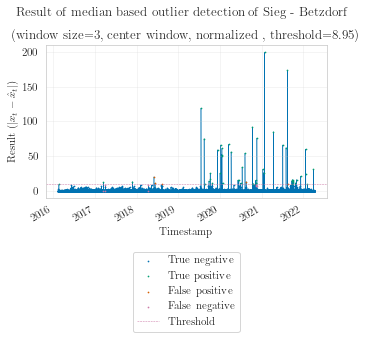

In [77]:
best_pred = prediction_summary_df.sort_values(by=['f1_score'], ascending=False).iloc[0]
common_id = best_pred['common_id']
model_type = best_pred['model_type']
window_size = int(best_pred['window_size']) if best_pred['window_size'] is not None else None
center_window = 'cw' if best_pred['center_window'] else 'ncw'
normalized = 'normalized' if best_pred['normalized'] else 'regular'
threshold = best_pred['threshold']
best_pred_df = pd.read_parquet(f'./data/predictions/raw_preprocessed/{normalized}/{common_id}/{window_size}_{center_window}_{model_type}.parquet')
best_pred_df.info()
best_pred_df['y_pred'] = np.where(best_pred_df['result'] > threshold, 1, 0)
best_pred_df['pred_type'] = best_pred_df.apply(lambda row: get_TP_TN_FP_FN(row['is_outlier'], row['y_pred']), axis=1)
# best_pred_df = best_pred_df.loc[best_pred_df['timestamp'] <= '2019-06-01']
tex_plots_path = f'../bachelor-thesis/plots/pdfs/{common_id}/'
fig, ax = plt.subplots(1, 1, figsize=set_size('thesis'))
plt.plot(best_pred_df['timestamp'], best_pred_df['result'], linewidth=0.5,
         zorder=-1)
# plt.scatter(best_pred_df.loc[~best_pred_df['is_outlier'], 'timestamp'],
#             best_pred_df.loc[~best_pred_df['is_outlier'], 'result'], s=0.1, label='regular (ground truth)')
# plt.scatter(best_pred_df.loc[best_pred_df['is_outlier'], 'timestamp'],
#             best_pred_df.loc[best_pred_df['is_outlier'], 'result'], s=0.5, c='C2', label='outliers (ground truth)')
plt.scatter(best_pred_df.loc[best_pred_df['pred_type'] == 'TN', 'timestamp'],
            best_pred_df.loc[best_pred_df['pred_type'] == 'TN', 'result'], s=0.5, c='C0', label='True negative')
plt.scatter(best_pred_df.loc[best_pred_df['pred_type'] == 'TP', 'timestamp'],
            best_pred_df.loc[best_pred_df['pred_type'] == 'TP', 'result'], s=0.5, c='C1', label='True positive')
plt.scatter(best_pred_df.loc[best_pred_df['pred_type'] == 'FP', 'timestamp'],
            best_pred_df.loc[best_pred_df['pred_type'] == 'FP', 'result'], s=0.5, c='C2', label='False positive')
plt.scatter(best_pred_df.loc[best_pred_df['pred_type'] == 'FN', 'timestamp'],
            best_pred_df.loc[best_pred_df['pred_type'] == 'FN', 'result'], s=0.5, c='C3', label='False negative')


plt.suptitle(f'Result of {model_type} based outlier detection of {stations_dict[common_id]["water_name"]} - {stations_dict[common_id]["station_name"]}',  y=1.05)
plt.title(f'(window size={window_size}, {"no " if not best_pred["center_window"] else ""} center window, {"not " if best_pred["normalized"] else ""} normalized , threshold={round(threshold, 2)})')
plt.grid(alpha=0.25)
plt.gcf().autofmt_xdate()
plt.xlabel('Timestamp')
plt.ylabel('Result ($|x_t - \hat{x}_t|$)')
plt.axhline(y=threshold, color='C3', linestyle='--', linewidth=0.5, label='Threshold')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.32))
plt.savefig(f'{tex_plots_path}od_result_{model_type}_{common_id}_all.pdf', format='pdf',
            bbox_inches='tight')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50569 entries, 0 to 50575
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   water_level  50569 non-null  float64            
 1   timestamp    50569 non-null  datetime64[ns, UTC]
 2   is_outlier   50569 non-null  bool               
 3   x_hat        50569 non-null  float64            
 4   result       50569 non-null  float64            
dtypes: bool(1), datetime64[ns, UTC](1), float64(3)
memory usage: 2.0 MB


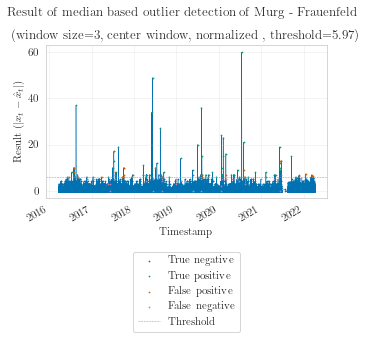

In [78]:
worst_best_pred = None
for common_id in prediction_summaries_dict.keys():
    if worst_best_pred is None:
        worst_best_pred = prediction_summaries_dict[common_id]['regular'].sort_values(by=['f1_score'], ascending=False).iloc[0]
    elif prediction_summaries_dict[common_id]['regular'].sort_values(by=['f1_score'], ascending=True).iloc[0]['f1_score'] >= worst_best_pred['f1_score']:
        worst_best_pred = prediction_summaries_dict[common_id]['regular'].sort_values(by=['f1_score'], ascending=False).iloc[0]

common_id = worst_best_pred['common_id']
model_type = worst_best_pred['model_type']
window_size = int(worst_best_pred['window_size']) if worst_best_pred['window_size'] is not None else None
center_window = 'cw' if worst_best_pred['center_window'] else 'nocw'
normalized = 'normalized' if worst_best_pred['normalized'] else 'regular'
threshold = worst_best_pred['threshold']
worst_best_df = pd.read_parquet(f'./data/predictions/raw_preprocessed/{normalized}/{common_id}/{window_size}_{center_window}_{model_type}.parquet')
worst_best_df.info()
worst_best_df['y_pred'] = np.where(worst_best_df['result'] > threshold, 1, 0)
worst_best_df['pred_type'] = worst_best_df.apply(lambda row: get_TP_TN_FP_FN(row['is_outlier'], row['y_pred']), axis=1)

# best_pred_df = best_pred_df.loc[best_pred_df['timestamp'] <= '2019-06-01']
tex_plots_path = f'../bachelor-thesis/plots/pdfs/{common_id}/'
fig, ax = plt.subplots(1, 1, figsize=set_size('thesis'))
plt.plot(worst_best_df['timestamp'], worst_best_df['result'], linewidth=0.5,
         zorder=-1)
# plt.scatter(worst_best_df.loc[~worst_best_df['is_outlier'], 'timestamp'],
#             worst_best_df.loc[~worst_best_df['is_outlier'], 'result'], s=0.1, label='regular (ground truth)')
# plt.scatter(worst_best_df.loc[worst_best_df['is_outlier'], 'timestamp'],
#             worst_best_df.loc[worst_best_df['is_outlier'], 'result'], s=0.5, c='C2', label='outliers (ground truth)')
plt.scatter(worst_best_df.loc[worst_best_df['pred_type'] == 'TN', 'timestamp'],
            worst_best_df.loc[worst_best_df['pred_type'] == 'TN', 'result'], s=0.5, c='C0', label='True negative')
plt.scatter(worst_best_df.loc[worst_best_df['pred_type'] == 'TP', 'timestamp'],
            worst_best_df.loc[worst_best_df['pred_type'] == 'TP', 'result'], s=0.5, c='C1', label='True positive')
plt.scatter(worst_best_df.loc[worst_best_df['pred_type'] == 'FP', 'timestamp'],
            worst_best_df.loc[worst_best_df['pred_type'] == 'FP', 'result'], s=0.5, c='C2', label='False positive')
plt.scatter(worst_best_df.loc[worst_best_df['pred_type'] == 'FN', 'timestamp'],
            worst_best_df.loc[worst_best_df['pred_type'] == 'FN', 'result'], s=0.5, c='C3', label='False negative')

plt.suptitle(f'Result of {model_type} based outlier detection of {stations_dict[common_id]["water_name"]} - {stations_dict[common_id]["station_name"]}',  y=1.05)
plt.title(f'(window size={window_size}, {"no " if not worst_best_pred["center_window"] else ""} center window, {"not " if worst_best_pred["normalized"] else ""} normalized , threshold={round(threshold, 2)})')
plt.grid(alpha=0.25)
plt.gcf().autofmt_xdate()
plt.xlabel('Timestamp')
plt.ylabel('Result ($|x_t - \hat{x}_t|$)')
plt.axhline(y=threshold, color='C3', linestyle='--', linewidth=0.5, label='Threshold')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.32))
plt.savefig(f'{tex_plots_path}od_result_{model_type}_{common_id}_all.pdf', format='pdf',
            bbox_inches='tight')


model type: mean
window size: 7
center window: cw
normalized: regular
threshold: 17.224080267558527
f1 score: 0.6842105263157895
precision: 0.7268817204301076
recall: 0.6462715105162524
<class 'pandas.core.frame.DataFrame'>
Int64Index: 27794 entries, 0 to 27800
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   water_level  27794 non-null  float64            
 1   timestamp    27794 non-null  datetime64[ns, UTC]
 2   is_outlier   27794 non-null  bool               
 3   x_hat        27794 non-null  float64            
 4   result       27794 non-null  float64            
dtypes: bool(1), datetime64[ns, UTC](1), float64(3)
memory usage: 1.1 MB
0.6842105263157895


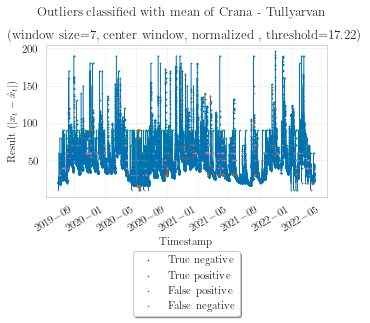

model type: z-score
window size: 26
center window: cw
normalized: normalized
threshold: 1.9933110367892977
f1 score: 0.6776677667766777
precision: 0.7979274611398963
recall: 0.5889101338432122
<class 'pandas.core.frame.DataFrame'>
Int64Index: 27794 entries, 0 to 27800
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   water_level  27794 non-null  float64            
 1   timestamp    27794 non-null  datetime64[ns, UTC]
 2   is_outlier   27794 non-null  bool               
 3   mean         27794 non-null  float64            
 4   std          27794 non-null  float64            
 5   result       27794 non-null  float64            
dtypes: bool(1), datetime64[ns, UTC](1), float64(4)
memory usage: 1.3 MB
0.6776677667766777


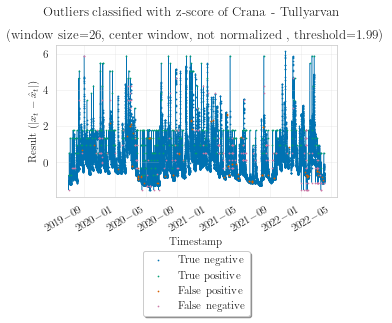

model type: median
window size: 3
center window: cw
normalized: regular
threshold: 8.946488294314381
f1 score: 0.9051094890510949
precision: 0.9253731343283582
recall: 0.8857142857142857
<class 'pandas.core.frame.DataFrame'>
Int64Index: 49511 entries, 0 to 49521
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   water_level  49511 non-null  float64            
 1   timestamp    49511 non-null  datetime64[ns, UTC]
 2   is_outlier   49511 non-null  bool               
 3   x_hat        49511 non-null  float64            
 4   result       49511 non-null  float64            
dtypes: bool(1), datetime64[ns, UTC](1), float64(3)
memory usage: 1.9 MB
0.9051094890510949


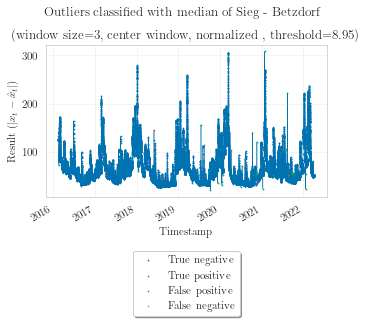

model type: madn-z-score
window size: 24
center window: cw
normalized: normalized
threshold: 3.648829431438127
f1 score: 0.7892049598832969
precision: 0.7451790633608816
recall: 0.8387596899224806
<class 'pandas.core.frame.DataFrame'>
Int64Index: 27153 entries, 0 to 27188
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   water_level  27153 non-null  float64            
 1   timestamp    27153 non-null  datetime64[ns, UTC]
 2   is_outlier   27153 non-null  bool               
 3   median       27153 non-null  float64            
 4   mad          27153 non-null  float64            
 5   madn         27153 non-null  float64            
 6   result       27153 non-null  float64            
dtypes: bool(1), datetime64[ns, UTC](1), float64(5)
memory usage: 1.5 MB
0.7892049598832969


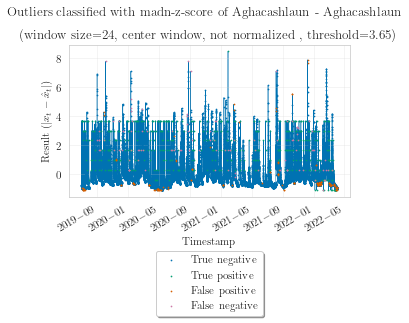

model type: mad
window size: 2
center window: nocw
normalized: normalized
threshold: 9.277591973244148
f1 score: 0.45454545454545453
precision: 0.5263157894736842
recall: 0.4
<class 'pandas.core.frame.DataFrame'>
Int64Index: 51012 entries, 0 to 51015
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   water_level  51012 non-null  float64            
 1   timestamp    51012 non-null  datetime64[ns, UTC]
 2   is_outlier   51012 non-null  bool               
 3   x_hat        51012 non-null  float64            
 4   result       51012 non-null  float64            
dtypes: bool(1), datetime64[ns, UTC](1), float64(3)
memory usage: 2.0 MB
0.45454545454545453


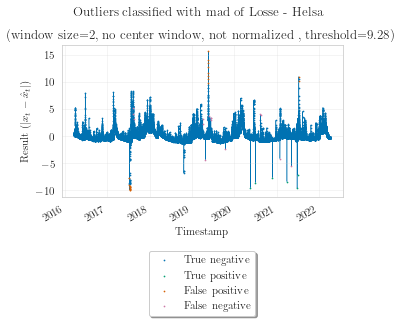

In [12]:
for mt in prediction_summary_df['model_type'].unique():
    best_pred_per_model = prediction_summary_df.loc[prediction_summary_df['model_type'] == mt].sort_values(by=['f1_score'], ascending=False).iloc[0]
    common_id = best_pred_per_model['common_id']
    model_type = best_pred_per_model['model_type']
    window_size = int(best_pred_per_model['window_size']) if best_pred_per_model['window_size'] is not None else None
    center_window = 'cw' if best_pred_per_model['center_window'] else 'nocw'
    normalized = 'normalized' if best_pred_per_model['normalized'] else 'regular'
    threshold = best_pred_per_model['threshold']
    print(f'model type: {model_type}')
    print(f'window size: {window_size}')
    print(f'center window: {center_window}')
    print(f'normalized: {normalized}')
    print(f'threshold: {threshold}')
    print(f'f1 score: {best_pred_per_model["f1_score"]}')
    print(f'precision: {best_pred_per_model["precision"]}')
    print(f'recall: {best_pred_per_model["recall"]}')
    best_pred_per_model_df = pd.read_parquet(f'./data/predictions/raw_preprocessed/{normalized}/{common_id}/{window_size}_{center_window}_{model_type}.parquet')
    best_pred_per_model_df.info()
    best_pred_per_model_df['y_pred'] = np.where(best_pred_per_model_df['result'] > threshold, 1, 0)
    best_pred_per_model_df['pred_type'] = best_pred_per_model_df.apply(lambda row: get_TP_TN_FP_FN(row['is_outlier'], row['y_pred']), axis=1)

    # best_pred_df = best_pred_df.loc[best_pred_df['timestamp'] <= '2019-06-01']
    tex_plots_path = f'../bachelor-thesis/plots/pdfs/{common_id}/'
    fig, ax = plt.subplots(1, 1, figsize=set_size('thesis'))
    plt.plot(best_pred_per_model_df['timestamp'], best_pred_per_model_df['water_level'], linewidth=0.5,
             zorder=-1)
    # plt.scatter(best_pred_per_model_df.loc[~best_pred_per_model_df['is_outlier'], 'timestamp'],
    #             best_pred_per_model_df.loc[~best_pred_per_model_df['is_outlier'], 'result'], s=0.1, label='regular (ground truth)')
    # plt.scatter(best_pred_per_model_df.loc[best_pred_per_model_df['is_outlier'], 'timestamp'],
    #             best_pred_per_model_df.loc[best_pred_per_model_df['is_outlier'], 'result'], s=0.5, c='C2', label='outliers (ground truth)')
    plt.scatter(best_pred_per_model_df.loc[best_pred_per_model_df['pred_type'] == 'TN', 'timestamp'],
                best_pred_per_model_df.loc[best_pred_per_model_df['pred_type'] == 'TN', 'water_level'], s=0.5, c='C0', label='True negative')
    plt.scatter(best_pred_per_model_df.loc[best_pred_per_model_df['pred_type'] == 'TP', 'timestamp'],
                best_pred_per_model_df.loc[best_pred_per_model_df['pred_type'] == 'TP', 'water_level'], s=0.5, c='C1', label='True positive')
    plt.scatter(best_pred_per_model_df.loc[best_pred_per_model_df['pred_type'] == 'FP', 'timestamp'],
                best_pred_per_model_df.loc[best_pred_per_model_df['pred_type'] == 'FP', 'water_level'], s=0.5, c='C2', label='False positive')
    plt.scatter(best_pred_per_model_df.loc[best_pred_per_model_df['pred_type'] == 'FN', 'timestamp'],
                best_pred_per_model_df.loc[best_pred_per_model_df['pred_type'] == 'FN', 'water_level'], s=0.5, c='C3', label='False negative')

    plt.suptitle(f'Outliers classified with {model_type} of {stations_dict[common_id]["water_name"]} - {stations_dict[common_id]["station_name"]}',  y=1.05)
    plt.title(f'(window size={window_size}, {"no " if not best_pred_per_model["center_window"] else ""} center window, {"not " if best_pred_per_model["normalized"] else ""} normalized , threshold={round(threshold, 2)})')
    plt.grid(alpha=0.25)
    plt.gcf().autofmt_xdate()
    plt.xlabel('Timestamp')
    plt.ylabel('Result ($|x_t - \hat{x}_t|$)')
    # plt.axhline(y=threshold, color='C3', linestyle='--', linewidth=0.5, label='Threshold')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.32),
              fancybox=True, shadow=True)
    plt.savefig(f'{tex_plots_path}od_{model_type}_{common_id}_all.pdf', format='pdf',
                bbox_inches='tight')
    print(f'{best_pred_per_model["f1_score"]}')
    plt.show()


model type: mean
window size: 7
center window: cw
normalized: regular
threshold: 17.224080267558527
f1 score: 0.6842105263157895
precision: 0.7268817204301076
recall: 0.6462715105162524
2019-08-03 15:00:00+00:00 - 2019-08-10 15:00:00+00:00


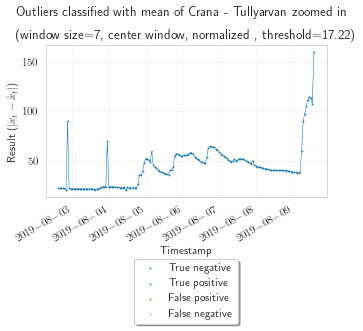

model type: z-score
window size: 26
center window: cw
normalized: normalized
threshold: 1.9933110367892977
f1 score: 0.6776677667766777
precision: 0.7979274611398963
recall: 0.5889101338432122
2019-08-18 15:00:00+00:00 - 2019-08-25 15:00:00+00:00


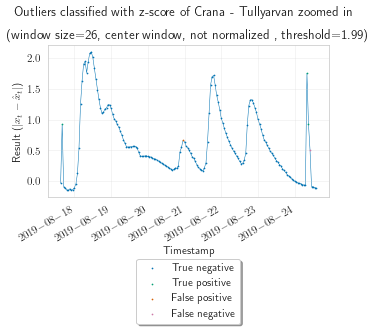

model type: median
window size: 3
center window: cw
normalized: regular
threshold: 8.946488294314381
f1 score: 0.9051094890510949
precision: 0.9253731343283582
recall: 0.8857142857142857
model type: madn-z-score
window size: 24
center window: cw
normalized: normalized
threshold: 3.648829431438127
f1 score: 0.7892049598832969
precision: 0.7451790633608816
recall: 0.8387596899224806
2019-09-23 15:00:00+00:00 - 2019-09-30 15:00:00+00:00


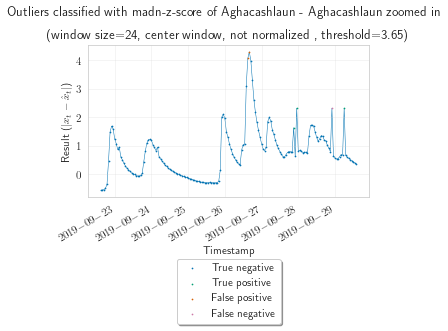

model type: mad
window size: 2
center window: nocw
normalized: normalized
threshold: 9.277591973244148
f1 score: 0.45454545454545453
precision: 0.5263157894736842
recall: 0.4


In [51]:
for mt in prediction_summary_df['model_type'].unique():
    best_pred_per_model = prediction_summary_df.loc[prediction_summary_df['model_type'] == mt].sort_values(by=['f1_score'], ascending=False).iloc[0]
    common_id = best_pred_per_model['common_id']
    model_type = best_pred_per_model['model_type']
    window_size = int(best_pred_per_model['window_size']) if best_pred_per_model['window_size'] is not None else None
    center_window = 'cw' if best_pred_per_model['center_window'] else 'nocw'
    normalized = 'normalized' if best_pred_per_model['normalized'] else 'regular'
    threshold = best_pred_per_model['threshold']
    print(f'model type: {model_type}')
    print(f'window size: {window_size}')
    print(f'center window: {center_window}')
    print(f'normalized: {normalized}')
    print(f'threshold: {threshold}')
    print(f'f1 score: {best_pred_per_model["f1_score"]}')
    print(f'precision: {best_pred_per_model["precision"]}')
    print(f'recall: {best_pred_per_model["recall"]}')
    best_pred_per_model_df = pd.read_parquet(f'./data/predictions/raw_preprocessed/{normalized}/{common_id}/{window_size}_{center_window}_{model_type}.parquet')
    # best_pred_per_model_df.info()
    best_pred_per_model_df['y_pred'] = np.where(best_pred_per_model_df['result'] > threshold, 1, 0)
    best_pred_per_model_df['pred_type'] = best_pred_per_model_df.apply(lambda row: get_TP_TN_FP_FN(row['is_outlier'], row['y_pred']), axis=1)
    tex_plots_path = f'../bachelor-thesis/plots/pdfs/{common_id}/'
    min_timestamp = best_pred_per_model_df['timestamp'].min()
    max_timestamp = best_pred_per_model_df['timestamp'].max()
    timedelta = np.timedelta64(7, 'D')
    increment = np.timedelta64(1, 'D')
    lower_window = min_timestamp
    upper_window = min_timestamp + timedelta
    while upper_window < max_timestamp:
        df_slice = best_pred_per_model_df.loc[(best_pred_per_model_df['timestamp'] >= lower_window) & (best_pred_per_model_df['timestamp'] < upper_window)]
        lower_window = lower_window + increment
        upper_window = upper_window + increment
        if len(df_slice['pred_type'].unique()) == 4:
            print(f'{lower_window} - {upper_window}')
            fig, ax = plt.subplots(1, 1, figsize=set_size('thesis'))
            plt.plot(df_slice['timestamp'], df_slice['water_level'], linewidth=0.5,
                     zorder=-1)
            plt.scatter(df_slice.loc[df_slice['pred_type'] == 'TN', 'timestamp'],
                        df_slice.loc[df_slice['pred_type'] == 'TN', 'water_level'], s=0.5, c='C0', label='True negative')
            plt.scatter(df_slice.loc[df_slice['pred_type'] == 'TP', 'timestamp'],
                        df_slice.loc[df_slice['pred_type'] == 'TP', 'water_level'], s=0.5, c='C1', label='True positive')
            plt.scatter(df_slice.loc[df_slice['pred_type'] == 'FP', 'timestamp'],
                        df_slice.loc[df_slice['pred_type'] == 'FP', 'water_level'], s=0.5, c='C2', label='False positive')
            plt.scatter(df_slice.loc[df_slice['pred_type'] == 'FN', 'timestamp'],
                        df_slice.loc[df_slice['pred_type'] == 'FN', 'water_level'], s=0.5, c='C3', label='False negative')

            plt.suptitle(f'Outliers classified with {model_type} of {stations_dict[common_id]["water_name"]} - {stations_dict[common_id]["station_name"]} zoomed in',  y=1.05)
            plt.title(f'(window size={window_size}, {"no " if not best_pred_per_model["center_window"] else ""} center window, {"not " if best_pred_per_model["normalized"] else ""} normalized , threshold={round(threshold, 2)})')
            plt.grid(alpha=0.25)
            plt.gcf().autofmt_xdate()
            plt.xlabel('Timestamp')
            plt.ylabel('Result ($|x_t - \hat{x}_t|$)')
            ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.37),
                      fancybox=True, shadow=True)
            plt.savefig(f'{tex_plots_path}od_{model_type}_{common_id}_zoomed.pdf', format='pdf',
            bbox_inches='tight')

            plt.show()
            break
